In [371]:
# hide

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

# Machine Learning mistakes
> "Non-obvious pitfalls to avoid in machine learning"
- toc: true
- branch: master
- hide: false
- search_exclude: true
- show_tags: true
- tags: [machine learning]

## Test data leakage

When choosing features for a regression or classification task out of a large number of potential features, one may first find the most correlated features with the target in the data set,
and then build a model and train on a train-test split.

The unobvious mistake is that when choosing the correlated features out of the whole dataset, before doing the train-test split, there is already information leakage from the test set to the training process, leading to potentially wrong conclusions.

To demonstrate it, consider completeley random data set of 1000 records, with 5000 features populated with random values from a normal distribution and a random target. 
We then select the top 100 features most correlated with the target are selected to train a model.

**Regression:**
Here we use the [F-statistic](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) as the measure of correlation between the features and target.

Create randomly distributed features and target:

In [403]:
np.random.seed(0)
X = np.random.rand(1000, 5000)
y = np.random.rand(1000)

First method (wrong): selecting best features then perform train-test split, train a linear regression model and evaluate.

In [404]:
X_new = SelectKBest(f_regression, k=100).fit_transform(X, y)

x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

model = LinearRegression().fit(x_train, y_train)
print(f"Model R^2 score: {model.score(x_test, y_test)}")

Model R^2 score: 0.3275513353773228


Second method: create a train-test split, then choose best features from training set, train a linear regression model and evalute.

In [405]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_new = SelectKBest(f_regression, k=100).fit_transform(x_train, y_train)

model = LinearRegression().fit(x_train, y_train)
print(f"Model R^2 score: {model.score(x_test, y_test)}")

Model R^2 score: -0.11827546107457221


We can see that the first method has a positive score for the linear regression model which is **spurious** and non-existed given we used comlpetley random data, 
whereas the second method has a negative $R^2$ indicating no linear correlation.
The non-negative correlation obtained in the first method is due to the test data leakage during the feature selection process.

We can repeat the process using cross validation as well:

First method: select features then perform cross validation:

In [406]:
X_new = SelectKBest(f_regression, k=100).fit_transform(X, y)

model = LinearRegression()

print(f"Cross validation mean score: {cross_val_score(model, X_new, y, cv=5).mean()}")

Cross validation mean score: 0.31089595750882204


Second method: Perform feature selection in each cross validation split:

In [407]:
select_k = SelectKBest(f_regression, k=100)
model = LinearRegression()

pipe = Pipeline(steps=[('k_best', select_k), ('model', model)])

print(f"Cross validation mean score: {cross_val_score(pipe, X, y, cv=5).mean()}")

Cross validation mean score: -0.3401749011815241


**Classification**

The problem can also be seen with a classification problem. Here we use [ANOVA F-value](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) statstic to measure correlation between feature and target.

In [408]:
X = np.random.randn(1000, 5000)
y = np.random.randint(low=0, high=2, size=(1000,)) # target classes = [0,1]

First method: selecting best featuers on entire dataset.

In [411]:
X_new = SelectKBest(f_classif, k=50).fit_transform(X, y)

model = LogisticRegression(solver='lbfgs')

cross_val_score(model, X_new, y, cv=10).mean()

0.710927092709271

Second method: Selecting best features within each training fold.

In [412]:
select_k = SelectKBest(k=50)
model = LogisticRegression(solver='lbfgs')

pipe = Pipeline(steps=[('k_best', select_k), ('model', model)])

cross_val_score(pipe, X, y, cv=5).mean()

0.48802495062376555

As expected the model performans is as good as random, expected given the random dataset.

The difference in the scores between the two methods is significant. The test data leakage results in a much better than random model, simply because the model
has indirectly been trained on the test set through the feature selection process.

## Out of sample prediction

This mistake applies to tree based models (random forest, xgboost, light gbm etc.) in which
one tries to obtain a prediction outside of the training domain of the model.
This is particularly evident in casess where there is a time-dependent feature and a trend in the data 

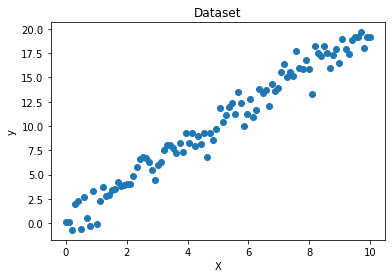

In [415]:
X = np.linspace(0, 10, 100)
y = 2*X + np.random.randn(100)

plt.scatter(X, y);
plt.xlabel('X')
plt.ylabel('y')
plt.title('Dataset');

Train-test split:

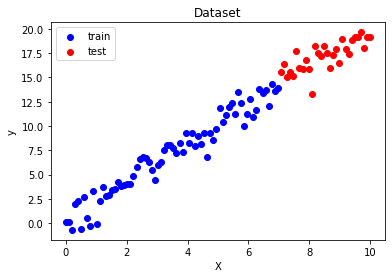

In [416]:
X_train = X[:int(len(X)*0.7)]
y_train = y[:int(len(X)*0.7)]

X_test = X[int(len(X)*0.7):]
y_test = y[int(len(X)*0.7):]

plt.scatter(X_train, y_train, label='train', color='blue');
plt.scatter(X_test, y_test, label='test', color='red');
plt.xlabel('X')
plt.ylabel('y')
plt.title('Dataset');
plt.legend();

Train a random forest model and evaluate on test set:

In [417]:
rf = RandomForestRegressor(n_estimators=10, max_depth=3).fit(X_train[:, np.newaxis], y_train)

Performance on training data:

In [419]:
rf.score(X_train[:, np.newaxis], y_train)

0.9626096946559975

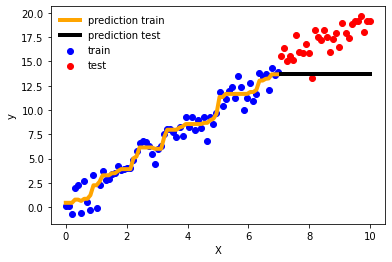

In [420]:
y_train_pred = rf.predict(X_train[:, np.newaxis])
y_test_pred = rf.predict(X_test[:, np.newaxis])

plt.scatter(X_train, y_train, label='train', color='blue');
plt.scatter(X_test, y_test, label='test', color='red');
plt.plot(X_train, y_train_pred, label='prediction train', color='orange', linewidth=4)
plt.plot(X_test, y_test_pred, label='prediction test', color='black', linewidth=4)
plt.xlabel('X')
plt.ylabel('y')
plt.legend(frameon=False);

We see in the plot that the model is incapable of predicting y for x values outside its training domain,
resulting in the flat black prediction line corresponding to the prediction for the x value at the boundary of the trainin set. This is despite the model being able to fit well the training data, shown with the purple line.